## Cosimulación

### Carga de librerías

In [1]:
# Librerías
%reset -f
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from LO_analytical import analyticalSolution
from LO_subsystems import mass_yF_uS, mass_yS_uF
from LO_properties import sys
from CosimManager import JacobiManagerSR
from IPython import display

### Parámetros

In [2]:
# Masa
m1 = 1.0
m2 = 1.0

# Rigidez
k1 = 10.0
k2 = 1000.0
kc = 100.0

# Amortiguamiento
c1 = 0
c2 = 0
cc = 0

# Condiciones iniciales
s10 = 0
s20 = 0
s1d0 = 100
s2d0 = -100

In [3]:
# Crea un sys con todos los parámetros
properties = sys(m1, m2, k1, k2, kc, c1, c2, cc, s10, s1d0, s20, s2d0)

### Esquema de coupling

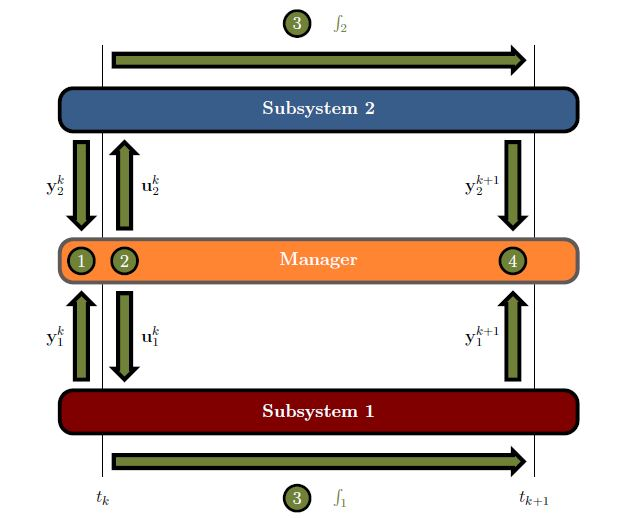

In [4]:
# Jacobi
display.Image("./Jacobi.jpg")

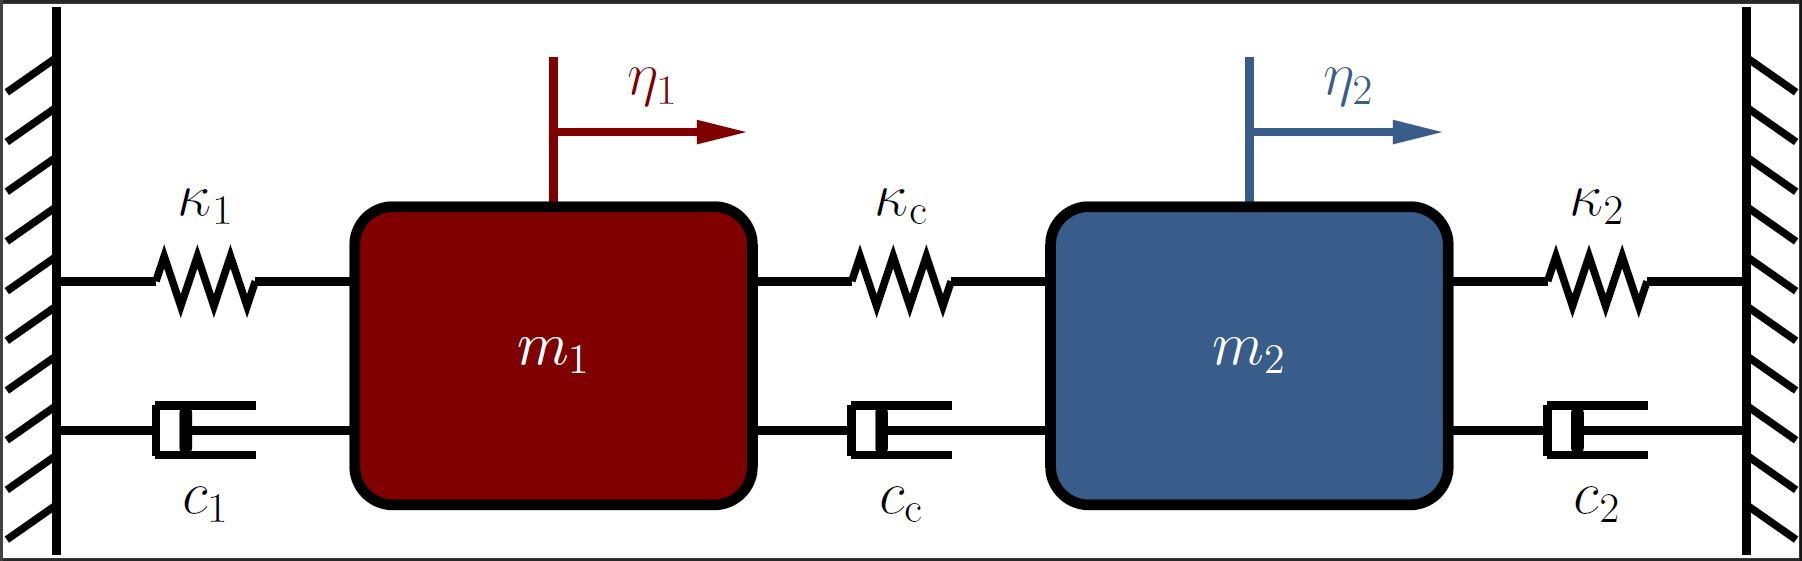

In [5]:
# Oscilador de 2 masas
display.Image("./LinearOscillator.jpg")

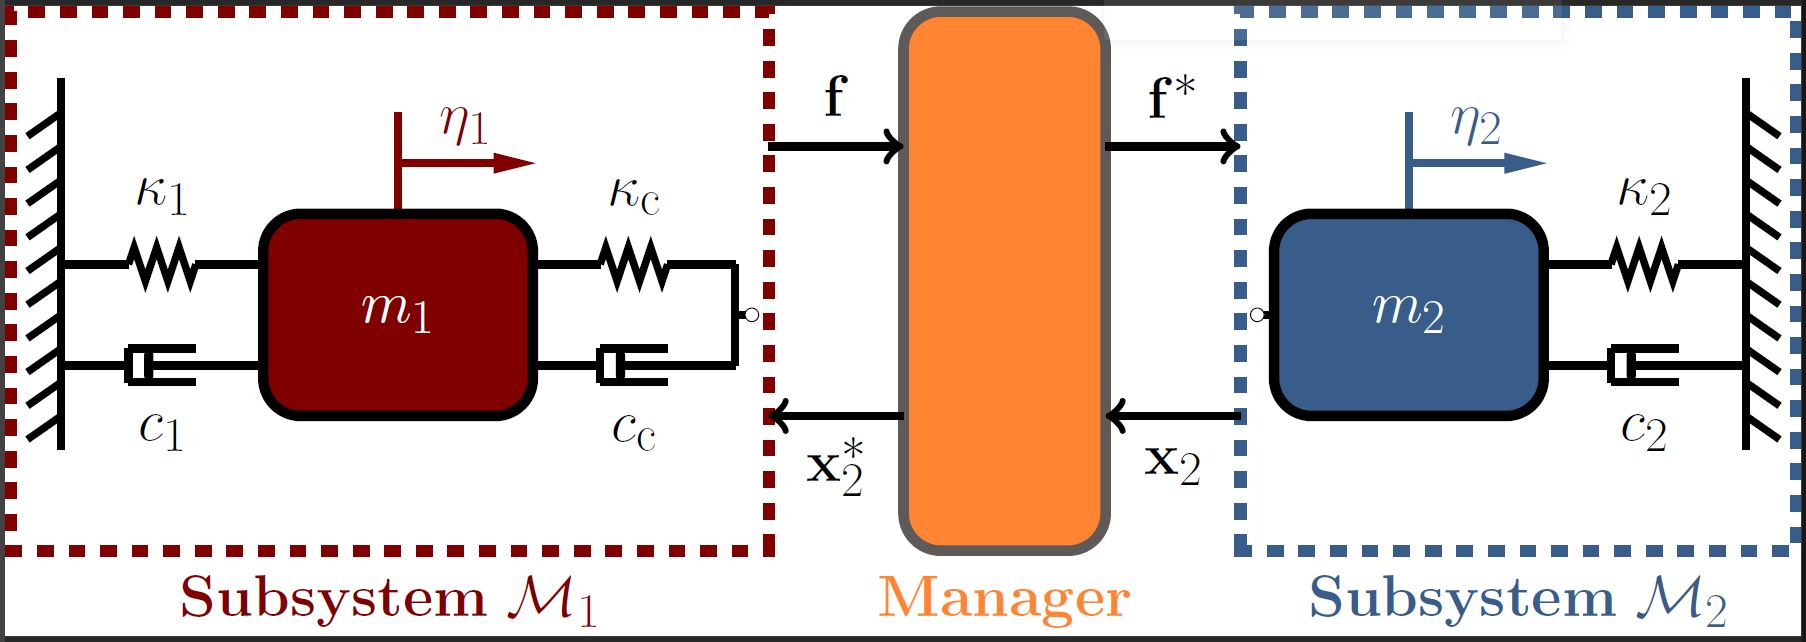

In [6]:
# Sistema cosimulado
display.Image("./LinearOscillatorCosim.jpg")

### Pasos de tiempo

In [4]:
# Pasos de tiempo
h1 = 1e-3
h2 = 1e-3
dt1 = 1e-3
dt2 = 1e-3
H = 1e-3

# Tiempo de simulación
tEnd = 10.0

### Solución analítica

In [5]:
# Solución analítica
analytical_t, analytical_s1, analytical_s1d, analytical_s1dd, analytical_s2, analytical_s2d, analytical_s2dd, analytical_fc, analytical_T, analytical_V, analytical_E, analytical_Wnc, analytical_WncAccSt, analytical_eigenValues, analytical_eigenVectors = analyticalSolution(sys = properties, H = H, t = tEnd)

### Solución cosimulada

In [6]:
# Instancias de ambos sistemas
ss1 = mass_yF_uS('SS1', properties, 1)
ss2 = mass_yS_uF('SS2', properties, 2)

# Manager single-rate
manager = JacobiManagerSR(properties, H, h1, h2, tEnd)

# Assigning subsystems
manager.assignSS1(ss1)
manager.assignSS2(ss2)

# Inicialización
y10, y20 = manager.initialize()
print('Initial solution: ')
print('Fc: ', -y10[0])
print('s2: ', y20[0])
print('s2d: ', y20[1])

# Loop
manager.run()

# Soluciones
cosim_t, cosim_fc, cosim_s1, cosim_s1d, cosim_s1dd, cosim_s2, cosim_s2d, cosim_s2dd, cosim_T, cosim_V, cosim_E, cosim_u = manager.getSTORE()

# Terminación
manager.terminate()

SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


In [7]:
# Solución cosimulada
dataframe = pd.DataFrame()
dataframe['Time'] = cosim_t
dataframe['s1*'] = cosim_s1
dataframe['s1d*'] = cosim_s1d
dataframe['s1dd*'] = cosim_s1dd
dataframe['s2*'] = cosim_s2
dataframe['s2d*'] = cosim_s2d
dataframe['s2dd*'] = cosim_s2dd
dataframe['f*'] = cosim_fc
dataframe['E*'] = cosim_E

# Solución analítica
dataframe['s1_ref'] = analytical_s1
dataframe['s1d_ref'] = analytical_s1d
dataframe['s1dd_ref'] = analytical_s1dd
dataframe['s2_ref'] = analytical_s2
dataframe['s2d_ref'] = analytical_s2d
dataframe['s2dd_ref'] = analytical_s2dd
dataframe['f_ref'] = analytical_fc
dataframe['E_ref'] = analytical_E

print(f'Rows: { dataframe.shape[0]} , Columns: {dataframe.shape[1]}')
dataframe.head()

Rows: 10001 , Columns: 17


,Time,s1*,s1d*,s1dd*,s2*,s2d*,s2dd*,f*,E*,s1_ref,s1d_ref,s1dd_ref,s2_ref,s2d_ref,s2dd_ref,f_ref,E_ref
0,0.000,0.000000,100.000000,0.000000,0.000000,-100.000000,0.000000,-0.000000,10000.000000,0.000000,100.000000,-0.000000,0.000000,-100.000000,0.000000,0.000000,10000.0
1,0.001,0.100000,100.000000,0.000000,-0.100000,-100.000000,0.000000,-10.000000,10007.050000,0.099997,99.989501,-20.997615,-0.099980,-99.940006,119.977651,-19.997650,10000.0
2,0.002,0.199979,99.979000,-21.000000,-0.199890,-99.890000,110.000000,-29.997900,10015.078995,0.199972,99.958010,-41.980924,-0.199840,-99.760089,239.821240,-39.981204,10000.0
3,0.003,0.299916,99.937013,-41.986690,-0.299550,-99.660112,229.887900,-49.980601,10023.055151,0.299906,99.905548,-62.935635,-0.299460,-99.460452,359.396852,-59.936580,10000.0
4,0.004,0.399790,99.874068,-62.945773,-0.398861,-99.310581,349.530713,-69.934019,10030.946711,0.399776,99.832153,-83.847488,-0.398721,-99.041430,478.570870,-79.849727,10000.0


In [8]:
# Guardar dataset
#dataframe.to_csv(path_or_buf = 'cosim_noDis.csv', index = False)

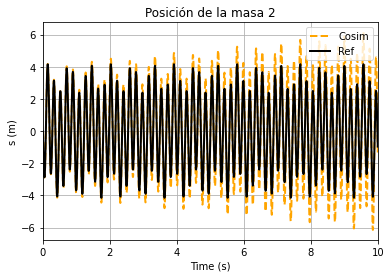

In [8]:
# Posiciones
plt.plot(dataframe['Time'], dataframe['s2*'], linestyle ='--', linewidth = 2, color = 'orange')
plt.plot(dataframe['Time'], dataframe['s2_ref'], linestyle ='-', linewidth = 2, color = 'black')
plt.title('Posición de la masa 2')
plt.ylabel('s (m)')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.legend(['Cosim', 'Ref'], loc = 'upper right')
plt.grid(True)
plt.show()

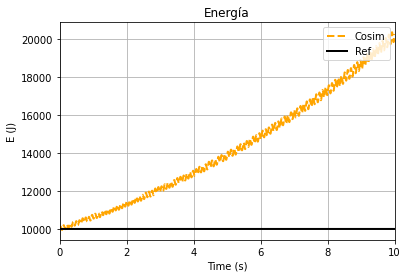

In [9]:
# Energía
plt.plot(dataframe['Time'], dataframe['E*'], linestyle ='--', linewidth = 2, color = 'orange')
plt.plot(dataframe['Time'], dataframe['E_ref'], linestyle ='-', linewidth = 2, color = 'black')
plt.title('Energía')
plt.ylabel('E (J)')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.legend(['Cosim', 'Ref'], loc = 'upper right')
plt.grid(True)
plt.show()

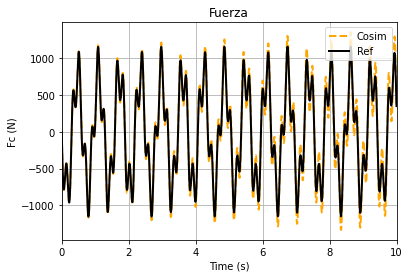

In [10]:
# Input fuerza
plt.plot(dataframe['Time'], cosim_u[:, 2], linestyle ='--', linewidth = 2, color = 'orange')
plt.plot(dataframe['Time'], analytical_fc, linestyle ='-', linewidth = 2, color = 'black')
plt.title('Fuerza')
plt.ylabel('Fc (N)')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.legend(['Cosim', 'Ref'], loc = 'upper right')
plt.grid(True)
plt.show()

### Cálculo coeficientes estimador

In [11]:
# Primero se calcula X donde se almacenan la fuerza actual y del paso anterior [1 f_actual f_anterior]
X = np.ones((10000, 3))
X[:, 1] = dataframe['f*'][1:]
X[:, 2] = dataframe['f*'][0:10000]
X


array([[  1.        , -10.        ,  -0.        ],
       [  1.        , -29.9979    , -10.        ],
       [  1.        , -49.98060133, -29.9979    ],
       ...,
       [  1.        , 380.86878545, 407.34672823],
       [  1.        , 354.39140222, 380.86878545],
       [  1.        , 327.93701052, 354.39140222]])

In [12]:
# Se guardan las fuerzas de la solución de referencia para el paso actual [f_actual ref]
y = np.zeros((10000,))
y = dataframe['f_ref'][1:]
y

1        -19.997650
2        -39.981204
3        -59.936580
4        -79.849727
5        -99.706636
            ...    
9996     424.603226
9997     405.864487
9998     387.106160
9999     368.342184
10000    349.586465
Name: f_ref, Length: 10000, dtype: float64

In [13]:
# Los coeficientes se calculan como theta = (X' * X)^-1 (X' * Y)
theta = np.matmul(X.transpose(), X)
theta = np.matmul(np.matmul(np.linalg.pinv(theta), X.transpose()), y)
theta

array([-0.76481219,  1.36609455, -0.43017082])

In [14]:
# Se lanzan varias iteraciones de la cosimulación, donde se van actuaizando los coeficientes 
# para cada iteración según las fuerzas de acoplamiento que salen.
# Es necesario limitar la corrección del estimador para que no se inestabilice la dinámica

def loop(theta, lim, ite):
    
    for _ in range(0, ite):

        # Instancias de ambos sistemas
        ss1 = mass_yF_uS('SS1', properties, 1)
        ss2 = mass_yS_uF('SS2', properties, 2)

        # Manager single-rate
        manager = JacobiManagerSR(properties, H, h1, h2, tEnd)

        # Assigning subsystems
        manager.assignSS1(ss1)
        manager.assignSS2(ss2)

        # Correction
        manager.correctionCoeffs(theta, lim) # Se introduce el nuevo estimador y el límite de corrección

        # Inicialización
        y10, y20 = manager.initialize()
        print('Initial solution: ')
        print('Fc: ', -y10[0])
        print('s2: ', y20[0])
        print('s2d: ', y20[1])

        # Loop
        manager.run()

        # Soluciones
        cosim_t, cosim_fc, cosim_s1, cosim_s1d, cosim_s1dd, cosim_s2, cosim_s2d, cosim_s2dd, cosim_T, cosim_V, cosim_E, cosim_u = manager.getSTORE()

        # Terminación
        manager.terminate()

        # Solución cosimulada
        dataframe = pd.DataFrame()
        dataframe['Time'] = cosim_t
        dataframe['s1*'] = cosim_s1
        dataframe['s1d*'] = cosim_s1d
        dataframe['s1dd*'] = cosim_s1dd
        dataframe['s2*'] = cosim_s2
        dataframe['s2d*'] = cosim_s2d
        dataframe['s2dd*'] = cosim_s2dd
        dataframe['f*'] = cosim_fc
        dataframe['E*'] = cosim_E

        # Solución analítica
        dataframe['s1_ref'] = analytical_s1
        dataframe['s1d_ref'] = analytical_s1d
        dataframe['s1dd_ref'] = analytical_s1dd
        dataframe['s2_ref'] = analytical_s2
        dataframe['s2d_ref'] = analytical_s2d
        dataframe['s2dd_ref'] = analytical_s2dd
        dataframe['f_ref'] = analytical_fc
        dataframe['E_ref'] = analytical_E

        # Posiciones
        plt.plot(dataframe['Time'], dataframe['s2*'], linestyle ='--', linewidth = 2, color = 'orange')
        plt.plot(dataframe['Time'], dataframe['s2_ref'], linestyle ='-', linewidth = 2, color = 'black')
        plt.title('Posición de la masa 2')
        plt.ylabel('s (m)')
        plt.xlabel('Time (s)')
        plt.xlim([0, 10])
        plt.legend(['Cosim', 'Ref'], loc = 'upper right')
        plt.grid(True)
        plt.show()

        # Velocidades
        plt.plot(dataframe['Time'], dataframe['s2d*'], linestyle ='--', linewidth = 2, color = 'orange')
        plt.plot(dataframe['Time'], dataframe['s2d_ref'], linestyle ='-', linewidth = 2, color = 'black')
        plt.title('Velocidad de la masa 2')
        plt.ylabel('sd (m/s)')
        plt.xlabel('Time (s)')
        plt.xlim([0, 10])
        plt.legend(['Cosim', 'Ref'], loc = 'upper right')
        plt.grid(True)
        plt.show()

        # Fuerza
        plt.plot(dataframe['Time'], cosim_fc, linestyle ='--', linewidth = 2, color = 'orange')
        plt.plot(dataframe['Time'], analytical_fc, linestyle ='-', linewidth = 2, color = 'black')
        plt.title('Fuerza')
        plt.ylabel('Fc (N)')
        plt.xlabel('Time (s)')
        plt.xlim([0, 10])
        plt.legend(['Cosim', 'Corr', 'Ref'], loc = 'upper right')
        plt.grid(True)
        plt.show()

        # Energía
        plt.plot(dataframe['Time'], dataframe['E*'], linestyle ='--', linewidth = 2, color = 'orange')
        plt.plot(dataframe['Time'], dataframe['E_ref'], linestyle ='-', linewidth = 2, color = 'black')
        plt.title('Energía')
        plt.ylabel('E (J)')
        plt.xlabel('Time (s)')
        plt.xlim([0, 10])
        plt.legend(['Cosim', 'Ref'], loc = 'upper right')
        plt.grid(True)
        plt.show()

        # Errores
        #print('Error en energía: ', np.sqrt((dataframe['E*'] * dataframe['E_ref']).sum()) / np.sqrt(10001))
        #print('Error en posición: ', np.sqrt((dataframe['s2*'] * dataframe['s2_ref']).sum()) / np.sqrt(10001))
        #print('Error en velocidad: ', np.sqrt((dataframe['s2d*'] * dataframe['s2d_ref']).sum()) / np.sqrt(10001))
        print('Estimador usado: ', theta)

        # Evaluar theta
        X = np.ones((10000, 3))
        X[:, 1] = dataframe['f*'][1:]
        X[:, 2] = dataframe['f*'][0:10000]

        y = np.zeros((10000,))
        y = dataframe['f_ref'][1:]

        theta = np.matmul(X.transpose(), X)
        theta = np.matmul(np.matmul(np.linalg.pinv(theta), X.transpose()), y)

    return dataframe
    
    

SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


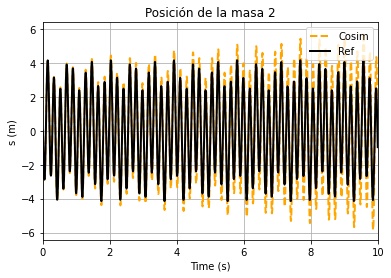

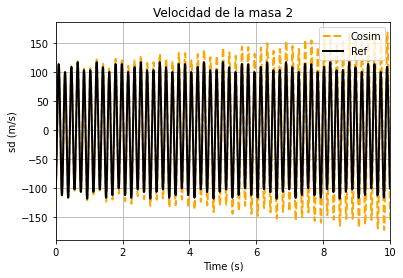

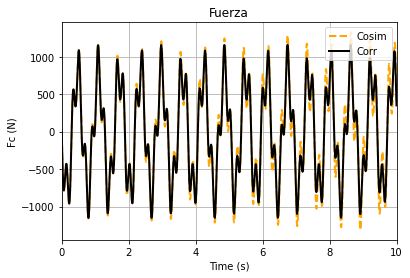

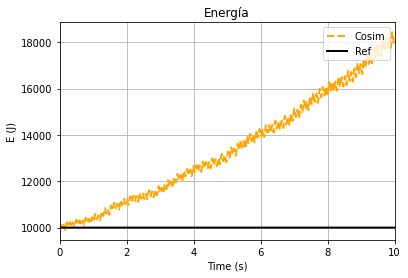

Estimador usado:  [-0.76481219  1.36609455 -0.43017082]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


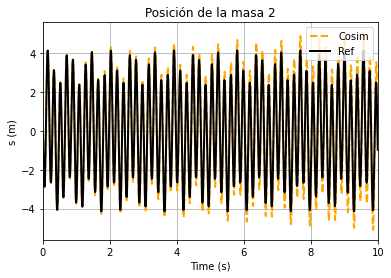

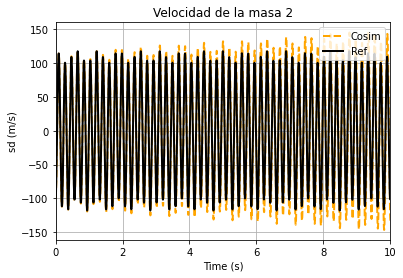

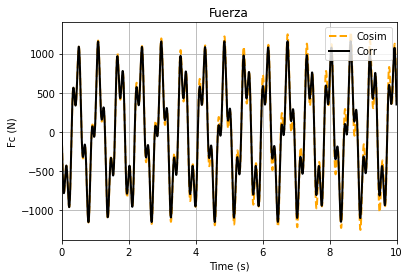

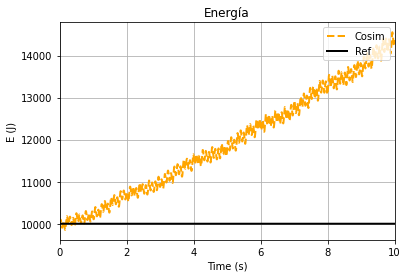

Estimador usado:  [-1.15127161  2.53911149 -1.59801147]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


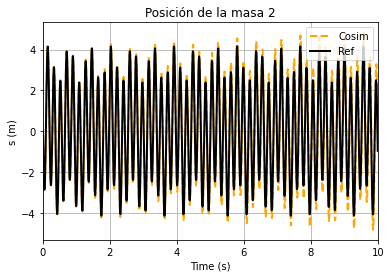

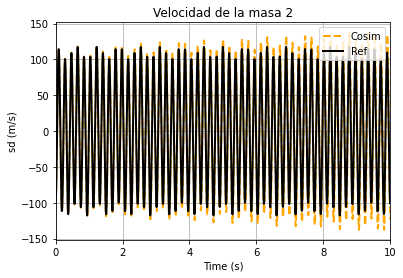

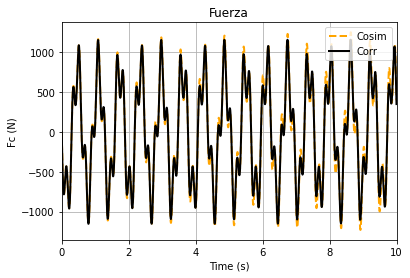

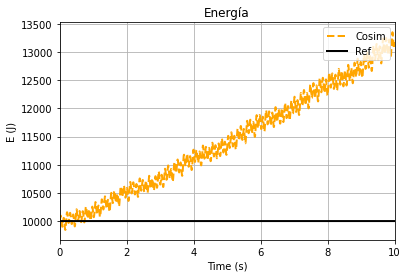

Estimador usado:  [-1.01950138  2.38453017 -1.42717005]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


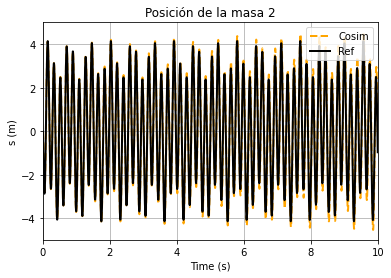

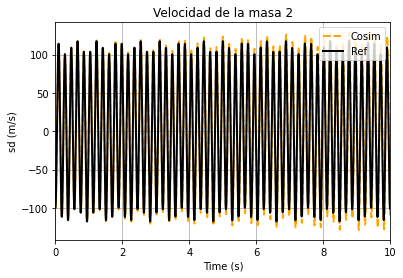

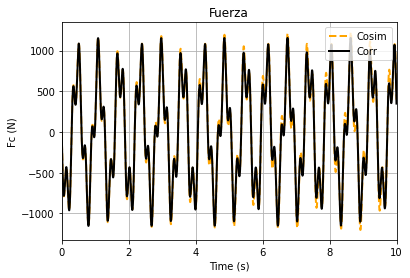

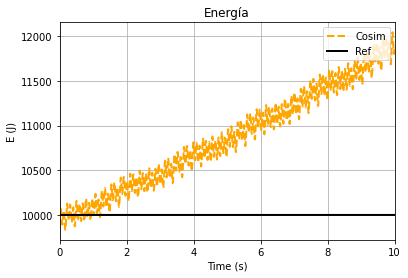

Estimador usado:  [-0.94158587  2.56920343 -1.60601221]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


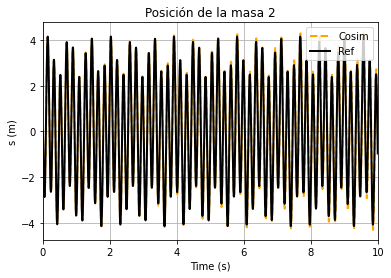

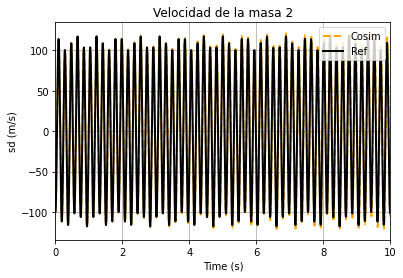

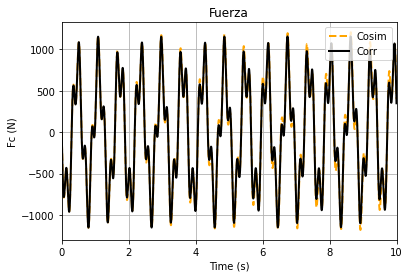

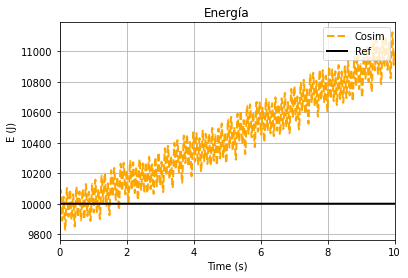

Estimador usado:  [-0.85335543  2.58568972 -1.61604179]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


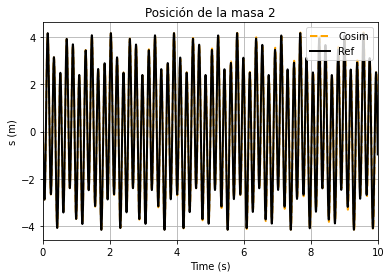

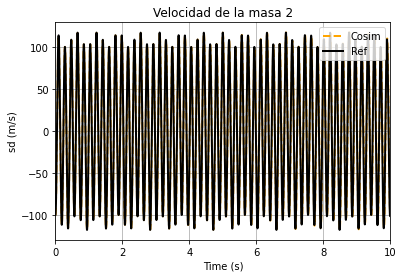

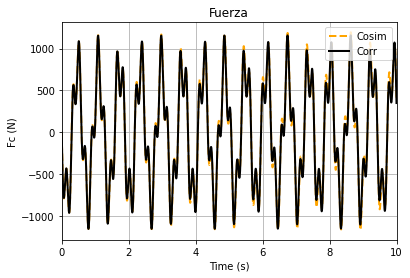

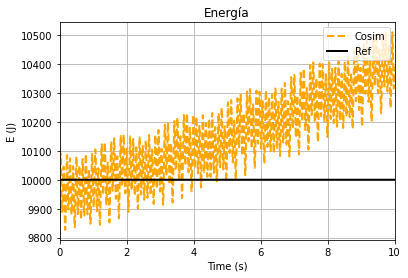

Estimador usado:  [-0.77346912  2.57316525 -1.59874917]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


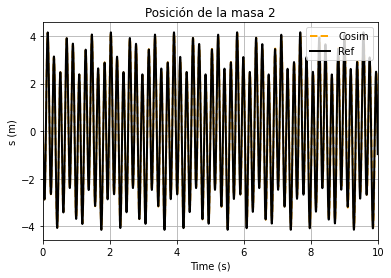

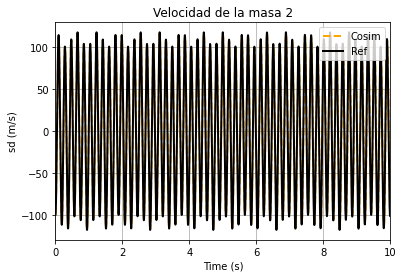

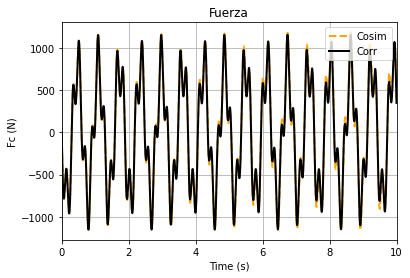

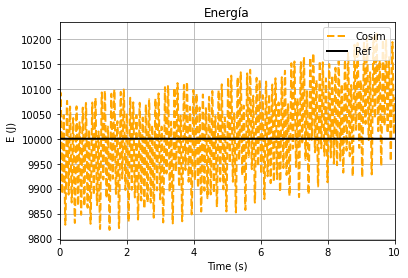

Estimador usado:  [-0.70917849  2.51807171 -1.54035129]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


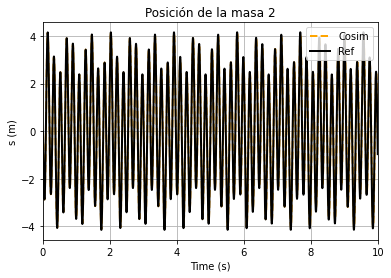

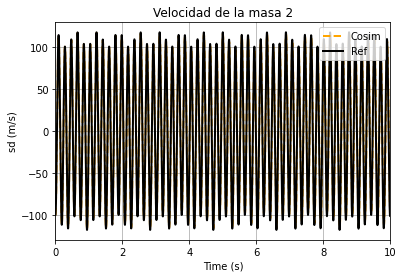

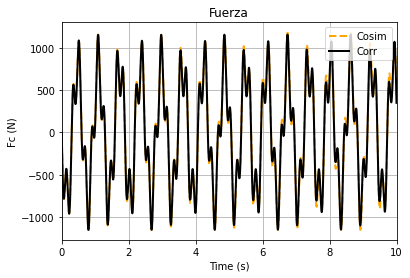

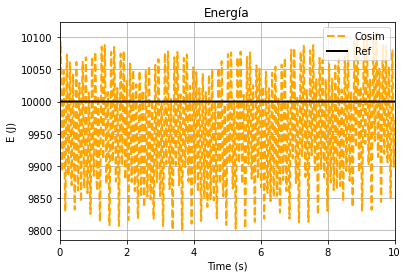

Estimador usado:  [-0.66772755  2.46536138 -1.48585473]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


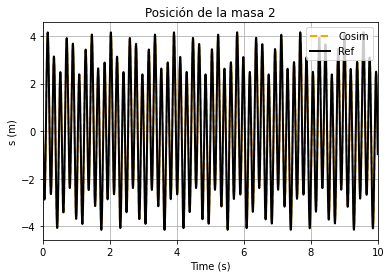

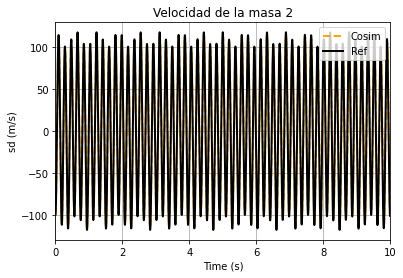

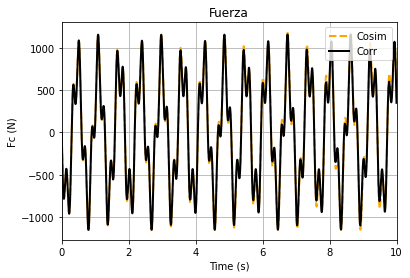

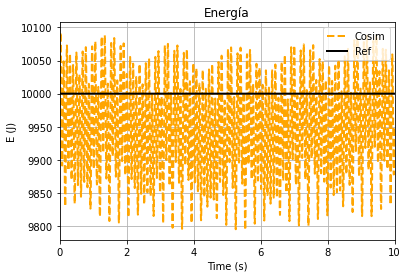

Estimador usado:  [-0.64796292  2.43538439 -1.45517517]
SS1 assigned correctly
SS2 assigned correctly
Initializing mass block 1
Initializing mass block 2
Initializing mass block 1
Initializing mass block 2
Initial solution: 
Fc:  -0.0
s2:  0.0
s2d:  -100.0
Macro time:  1.0 s
Macro time:  2.0 s
Macro time:  3.0 s
Macro time:  4.0 s
Macro time:  5.0 s
Macro time:  6.0 s
Macro time:  7.0 s
Macro time:  8.0 s
Macro time:  9.0 s
Macro time:  10.0 s
Terminating mass block  1 time:  10.0 s
Terminating mass block  2 time:  10.0 s


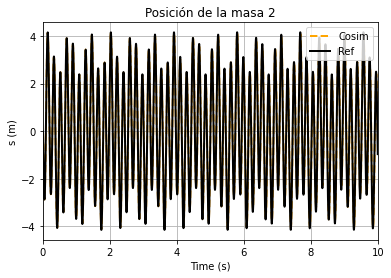

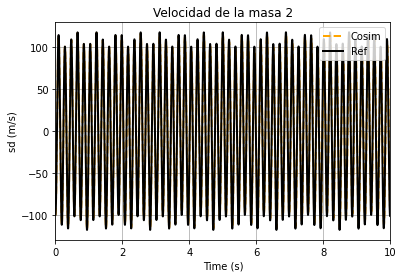

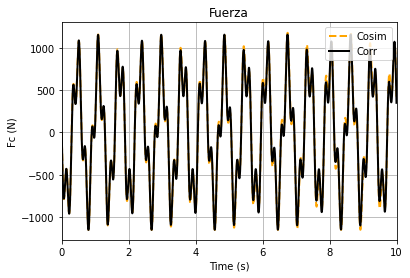

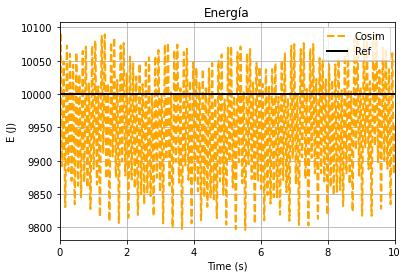

Estimador usado:  [-0.64178241  2.42582325 -1.44545183]


In [15]:
df = loop(theta, 18, 10)

In [24]:
# Guardar dataset
df.to_csv(path_or_buf = 'lo_noDis.csv', index = False)

df2 = pd.read_csv('lo_noDis.csv', skiprows=lambda x: (x-1)%10 != 0, header=None)
df2.to_csv(path_or_buf = 'lo_noDis.csv', index = False)